# Prepocessing dataset

In [1]:
import os
import numpy as np
import pandas as pd
import tqdm.notebook as tq
import matplotlib.pyplot as plt
import warnings
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_colwidth',None)

In [2]:
df_train = pd.read_csv("data/emotion_detection_group_old.csv").loc[lambda x: x["emotion"] != "neutral"]
df_test = pd.read_csv("data/all_labels.csv")

In [3]:
df_train.to_csv("data/emotion_detection_group_old_comp.csv", compression="zip", index=False)

In [4]:
df_train.shape, df_test.shape

((547028, 2), (1436, 3))

In [5]:
#df_train = pd.concat([df_disgust, df_train])
print(df_train.shape)
df_train['emotion'].value_counts().sort_values()

(547028, 2)


emotion
disgust        5550
surprise      35989
fear          59695
anger         77918
sadness      143454
happiness    224422
Name: count, dtype: int64

In [6]:
def balancing_multiple_classes(final_df, emotion_column_name):
    # Get the minimum count of samples among all classes
    min_count = final_df[emotion_column_name].value_counts().min()
    
    # Create an empty DataFrame to store the balanced data
    balanced_df = pd.DataFrame(columns=final_df.columns)
    
    # Iterate over unique emotions
    for emotion in final_df[emotion_column_name].unique():
        emotion_df = final_df[final_df[emotion_column_name] == emotion]        
        if len(emotion_df) > min_count:
            emotion_df = emotion_df.sample(n=min_count, random_state=1)
        
        balanced_df = pd.concat([balanced_df, emotion_df])
    balanced_df = balanced_df.sample(frac=1, random_state=1).reset_index(drop=True)
    
    return balanced_df

In [7]:
df_balanced = balancing_multiple_classes(df_train,'emotion')
df_balanced['emotion'].value_counts()

emotion
happiness    5550
sadness      5550
anger        5550
fear         5550
surprise     5550
disgust      5550
Name: count, dtype: int64

In [8]:
emotion_dummies_train = pd.get_dummies(df_train['emotion'])
emotion_dummies_train = emotion_dummies_train.astype(int)

emotion_dummies_test = pd.get_dummies(df_test['emotion'])
emotion_dummies_test = emotion_dummies_test.astype(int)

In [9]:
df_train_main = pd.concat([df_train['sentence'], emotion_dummies_train], axis=1)
df_test_main = pd.concat([df_test['sentence'], emotion_dummies_test], axis=1)

df_test_main.head(4)

,sentence,anger,disgust,fear,happiness,sadness,surprise
0,Girls are happy when they get flowers,0,0,0,1,0,0
1,His jaw dropped in disbelief when he saw the price of the concert tickets.,0,0,0,0,0,1
2,Sometimes the ugly stench makes me wanna throw up.,0,1,0,0,0,0
3,The foul odor from the garbage bin was disgusting.,0,1,0,0,0,0


In [10]:
sample = df_train_main.sample(n = 1000, random_state = 4)
columns = sample.columns
freq = sample[columns[2:]].sum()/sample.shape[0]
freq

disgust      0.015
fear         0.116
happiness    0.394
sadness      0.265
surprise     0.063
dtype: float64

In [11]:
sample.head()

,sentence,anger,disgust,fear,happiness,sadness,surprise
528526,Well . . . perhaps you should think about it .,1,0,0,0,0,0
126699,Haha if only he had reddit,0,0,0,1,0,0
324090,i feel good and am gaining weight much better than i did with diego,0,0,0,1,0,0
482598,i am feeling a bit unsure of myself as i document the beautiful birth of my fourth child,0,0,1,0,0,0
502760,i feel so disgusted as i type this,1,0,0,0,0,0


# LLama Multi-class text classification

In [12]:
import torch
import torch.nn as nn

from collections import defaultdict
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

#from transformers import LlamaForCausalLM, LlamaTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

from scripts.llama_tokenizer import TokenizedDataset
from scripts.llama_model import LLamaClass
from transformers import AutoTokenizer, LlamaForCausalLM

In [13]:
#!pip install transformers

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')

In [15]:
#df_train_main = sample
#df_train_main = df_train_main.sample(frac=1).reset_index(drop=True)

training_df, validation_df = train_test_split(df_train_main, random_state=77, test_size=0.30, shuffle=True)
testing_df = df_test_main.copy()

In [16]:
print(f"Train: {training_df.shape}, Val: {validation_df.shape}, Test: {testing_df.shape}")

Train: (382919, 7), Val: (164109, 7), Test: (1436, 7)


In [17]:
# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8
EPOCHS = 1
LEARNING_RATE = 1e-05
WEIGHT_DECAY = 0.001

In [18]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

In [19]:
tokenizer.add_special_tokens({"pad_token":"<pad>"})
tokenizer.pad_token_id = tokenizer.vocab_size - 1

In [20]:
test_text = training_df['sentence'].sample().iloc[0]

encodings = tokenizer.encode_plus(test_text, 
                                  add_special_tokens = True,
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length", 
                                  return_attention_mask = True, 
                                  return_tensors = "pt")

print(f"original sentence: \n{test_text}\n")
print(f"tokenized sentence: \n{encodings}")

original sentence: 
That depends do you have legs ?

tokenized sentence: 
{'input_ids': tensor([[    1,  2193,  7111,   437,   366,   505, 21152,  1577, 31999, 31999,
         31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999,
         31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999,
         31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999,
         31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}


In [21]:
emotion_list = emotion_dummies_train.columns.tolist()
emotion_list

['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']

In [22]:
train_dataset = TokenizedDataset(training_df, tokenizer, MAX_LEN, emotion_list)
val_dataset = TokenizedDataset(validation_df, tokenizer, MAX_LEN, emotion_list)
test_dataset = TokenizedDataset(testing_df, tokenizer, MAX_LEN, emotion_list)

In [23]:
next(iter(test_dataset))

{'input_ids': tensor([    1, 23992,   526,  9796,   746,   896,   679, 18281, 31999, 31999,
         31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999,
         31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999,
         31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999,
         31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999,
         31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999,
         31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999,
         31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999,
         31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999,
         31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999,
         31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999,
         31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999, 31999,
         31999, 31999, 31999, 31999, 31

In [24]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(val_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [25]:
model = LLamaClass()
model.to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LLamaClass(
  (llama): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (dropout): Dropo

In [26]:
# Loss function
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [27]:
# Adam Optimizer 
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8, no_deprecation_warning=True)

In [28]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer):
    print("Training:")

    losses = []
    correct_predictions = 0
    num_samples = 0
    
    model.train()
    
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), 
                      leave=True, colour='steelblue')
    
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        emotions = data['emotion'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) 
        loss = loss_fn(outputs, emotions)
        losses.append(loss.item())
        losses.append(loss.item())
        
        # training accuracy
        _, preds = torch.max(outputs, dim=1) # batch dim 
        _, emotion = torch.max(emotions, dim=1)  # batch dim
        num_samples += len(emotion)  
        correct_predictions += torch.sum(preds == emotion)

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()


    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [29]:
def eval_model(validation_loader, model, optimizer):
    print("Evaluating:")
    
    losses = []
    correct_predictions = 0
    num_samples = 0
    
    model.eval()
    loop = tq.tqdm(enumerate(validation_loader), total=len(validation_loader), 
                      leave=True, colour='#8B0000')

    with torch.no_grad():
        for batch_idx, data in loop:
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            emotions = data['emotion'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            

            loss = loss_fn(outputs, emotions)
            losses.append(loss.item())

            # validation accuracy
            _, preds = torch.max(outputs, dim=1) 
            _, emotion = torch.max(emotions, dim=1) 
            num_samples += len(emotion) 
            correct_predictions += torch.sum(preds == emotion)

    return float(correct_predictions)/num_samples, np.mean(losses)

# Model Training

In [30]:
model.llama.config.pad_token_id = tokenizer.pad_token_id

In [31]:
model.llama.config

LlamaConfig {
  "_name_or_path": "meta-llama/Llama-2-7b-hf",
  "architectures": [
    "LlamaForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 11008,
  "max_position_embeddings": 4096,
  "model_type": "llama",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 32,
  "pad_token_id": 31999,
  "pretraining_tp": 1,
  "rms_norm_eps": 1e-05,
  "rope_scaling": null,
  "rope_theta": 10000.0,
  "tie_word_embeddings": false,
  "torch_dtype": "float16",
  "transformers_version": "4.39.1",
  "use_cache": true,
  "vocab_size": 32000
}

In [32]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        #torch.save(model.state_dict(), os.path.join("models","roberta_model_3.pth"))
        best_accuracy = val_acc

Epoch 1/1
Training:


  0%|          | 0/47865 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 11.99 GiB of which 0 bytes is free. Of the allocated memory 26.33 GiB is allocated by PyTorch, and 23.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

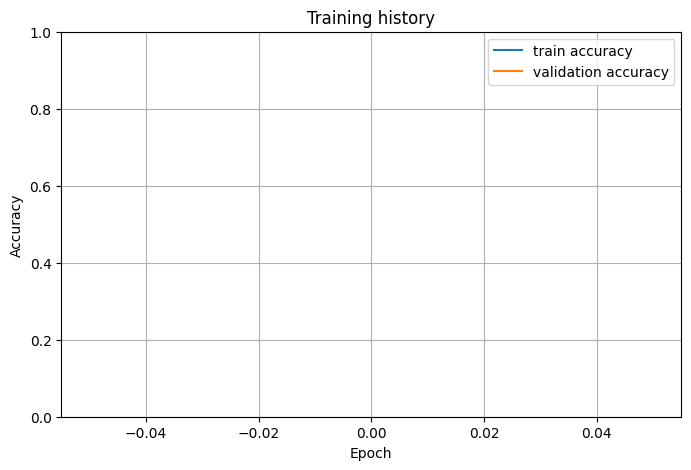

In [ ]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
plt.grid()

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    sentences = []
    predictions = []
    prediction_probs = []
    emotion_values = []

    with torch.no_grad():
      for data in data_loader:
        sentence = data["sentence"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        emotions = data["emotion"].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        _, preds = torch.max(outputs, dim=1)
        _, emotion = torch.max(emotions, dim=1)

        sentences.extend(sentence)
        predictions.extend(preds.tolist())                     # Convert tensor to list
        prediction_probs.extend(outputs.tolist())              # Convert tensor to list
        emotion_values.extend(emotions.argmax(dim=1).tolist())  # Convert tensor to list
     
    return sentences, predictions, prediction_probs, emotion_values

In [ ]:
sentences, predictions, prediction_probs, emotion_values = get_predictions(model, test_data_loader)

In [ ]:
print(classification_report(emotion_values, predictions, target_names=emotion_list))

              precision    recall  f1-score   support

       anger       0.86      0.75      0.80       253
     disgust       0.76      0.90      0.82       199
        fear       0.87      0.88      0.87       215
   happiness       0.88      0.95      0.92       263
     sadness       0.85      0.82      0.83       289
    surprise       0.89      0.81      0.85       217

    accuracy                           0.85      1436
   macro avg       0.85      0.85      0.85      1436
weighted avg       0.85      0.85      0.85      1436



In [ ]:
emotion_mapping = {'anger': 0, 'disgust': 1, 'fear': 2, 'happiness': 3, 'sadness': 4, 'surprise': 5}

In [ ]:
predicted_emotions = [emotion for label in predictions for emotion, encoded_label in emotion_mapping.items() if label == encoded_label]
len(predicted_emotions)

1436

In [ ]:
# best so far 0.7588
# best for 1 epoch unbalanced 0.83 
print('F1 score on test set: {}'.format(f1_score(df_test['emotion'], predicted_emotions, average='weighted')))

F1 score on test set: 0.8501911273023104


In [ ]:
submission = pd.DataFrame({
    'id': df_test['id'],
    'emotion': predicted_emotions,
    'sentence' : df_test['sentence']
})

In [ ]:
submission = submission[['id', 'emotion']]

In [ ]:
if submission.columns.tolist() == ['id', 'emotion'] and submission.shape == (1436, 2):
    torch.save(model.state_dict(), os.path.join("models","robert_test.bin"))
    submission.to_csv("submissions/roberta_test2.csv", index=False)

RuntimeError: Parent directory models does not exist.

In [ ]:
# Ensure num_labels matches the number of unique labels
unique_labels = df['emotion'].nunique()
model = LlamaForSequenceClassification.from_pretrained("meta-llama/Llama-2-7b-hf", num_labels=unique_labels)

# Double-check the encoded labels
print("Unique labels in the dataset:", sorted(df['emotion'].unique()))

# Verify that there are no unexpected values
assert df['emotion'].max() < unique_labels, "Found a label index higher than num_labels - 1"
assert df['emotion'].min() >= 0, "Found a label index lower than 0"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-2-7b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Unique labels in the dataset: [0, 1, 2, 3, 4, 5]


In [ ]:
first_batch = next(iter(dataset))
print("First batch labels:", first_batch['labels'])

First batch labels: 2


In [ ]:
from torch.utils.data import DataLoader

# Assuming your dataset is already created
dataset = EmotionDataset(encodings, df['emotion'].values)

# Create a DataLoader to handle batching
batch_size = 8  # You can adjust the batch size as needed
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Now, iterate over the DataLoader, not the dataset
for i, batch in enumerate(data_loader):
    if i >= 5:  # Check the first 5 batches
        break
    print(f"Batch {i} labels:", batch['labels'])
    # Now batch['labels'] should be a list/array/tensor
    assert isinstance(batch['labels'], (list, np.ndarray, torch.Tensor)), "Labels should be a list, numpy array, or torch Tensor."


NameError: name 'Dataset' is not defined

In [ ]:
from transformers import LlamaTokenizer, LlamaForSequenceClassification, TrainingArguments, Trainer
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch

# Load your dataframe (adjust the path as needed)
df = pd.read_csv("data/emotion_detection_group_old.csv").loc[lambda x: x["emotion"] != "neutral"]

# Initialize the tokenizer
tokenizer = LlamaTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
tokenizer.add_special_tokens({"pad_token":"<pad>"})
pad_token_id = tokenizer.pad_token_id
# Encode the labels
label_encoder = LabelEncoder()
df['emotion'] = label_encoder.fit_transform(df['emotion'])

class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Tokenize the sentences
encodings = tokenizer(df['sentence'].tolist(), truncation=True, padding=True, max_length=512)

# Create the dataset
dataset = EmotionDataset(encodings, df['emotion'].values)

# Define the DataLoader
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

if tokenizer.pad_token_id >= tokenizer.vocab_size:
    new_pad_token_id = tokenizer.vocab_size - 1  # Last index in the vocabulary
    tokenizer.pad_token_id = new_pad_token_id
    print("New tokenizer pad_token_id:", tokenizer.pad_token_id)

# Load the Llama model with the correct number of labels
model = LlamaForSequenceClassification.from_pretrained(
    "meta-llama/Llama-2-7b-hf",
    num_labels=len(label_encoder.classes_),
    pad_token_id=tokenizer.pad_token_id
)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    no_cuda=True,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=dataset,               # training dataset
)

# Train the model
trainer.train()


New tokenizer pad_token_id: 31999


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-2-7b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\wesle\anaconda3\envs\bert_nlp\Lib\site-packages\transformers\training_args.py:1399: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(
c:\Users\wesle\anaconda3\envs\bert_nlp\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_samp

  0%|          | 0/205137 [00:00<?, ?it/s]

IndexError: index out of range in self

In [ ]:
print("Tokenizer pad_token_id:", tokenizer.pad_token_id)


In [ ]:
# Adjusted from the standard Trainer to add debugging information
from transformers import Trainer

class DebugTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        try:
            return super().compute_loss(model, inputs, return_outputs=return_outputs)
        except IndexError as e:
            print(f"Error with input IDs: {inputs['input_ids']}")
            print(f"Error with attention mask: {inputs['attention_mask']}")
            print(f"Error with labels: {inputs['labels']}")
            raise e

# Initialize the DebugTrainer instead of the regular Trainer
trainer = DebugTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
)

# Attempt to train
try:
    trainer.train()
except IndexError:
    print("Index error during training, inputs printed above.")


  0%|          | 0/205137 [00:00<?, ?it/s]

Error with input IDs: tensor([[    1,   474,   505,  ..., 32000, 32000, 32000],
        [    1,   306, 13818,  ..., 32000, 32000, 32000],
        [    1,   474,  4459,  ..., 32000, 32000, 32000],
        ...,
        [    1,   474,   626,  ..., 32000, 32000, 32000],
        [    1,   474,  4459,  ..., 32000, 32000, 32000],
        [    1, 15011,  1919,  ..., 32000, 32000, 32000]])
Error with attention mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Error with labels: tensor([0, 3, 4, 4, 3, 3, 3, 3])
Index error during training, inputs printed above.


In [ ]:
# Adjust the tokenizer's pad_token_id
tokenizer.pad_token_id = tokenizer.vocab_size - 1
print("Adjusted tokenizer's pad_token_id:", tokenizer.pad_token_id)

# Re-tokenize the dataset
encodings = tokenizer(df['sentence'].tolist(), truncation=True, padding=True, max_length=512)

# Ensure no token ID equals the previously problematic 32000
assert all(32000 not in seq for seq in encodings['input_ids']), "Old pad token ID is still present in the encodings."

# Create the dataset and DataLoader again
dataset = EmotionDataset(encodings, df['emotion'].values)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Initialize the DebugTrainer with the new dataset
trainer = DebugTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
)

# Attempt to train
try:
    trainer.train()
except IndexError as e:
    print("Index error during training, inputs printed above.")


Adjusted tokenizer's pad_token_id: 31999


  0%|          | 0/205137 [00:00<?, ?it/s]